In [ ]:
import pandas as _hex_pandas
import datetime as _hex_datetime
import json as _hex_json

In [ ]:
hex_scheduled = _hex_json.loads("false")

In [ ]:
hex_user_email = _hex_json.loads("\"example-user@example.com\"")

In [ ]:
hex_run_context = _hex_json.loads("\"logic\"")

In [ ]:
hex_timezone = _hex_json.loads("\"UTC\"")

In [ ]:
hex_project_id = _hex_json.loads("\"0b769c8c-aa20-48ad-aded-9b607436fef0\"")

In [ ]:
hex_project_name = _hex_json.loads("\"Trend\"")

In [ ]:
hex_status = _hex_json.loads("\"\"")

In [ ]:
hex_categories = _hex_json.loads("[]")

In [ ]:
hex_color_palette = _hex_json.loads("[\"#4C78A8\",\"#F58518\",\"#E45756\",\"#72B7B2\",\"#54A24B\",\"#EECA3B\",\"#B279A2\",\"#FF9DA6\",\"#9D755D\",\"#BAB0AC\"]")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import pandas as pd


In [ ]:
date_range = pd.date_range(start="2023-01-01", end="2023-12-31", freq='D')
n = len(date_range)

base_trend = np.sin(np.linspace(0, 2 * np.pi, n)) * 20 + 50  # Base trend

spring_start, spring_end = '2023-03-01', '2023-05-31'
summer_start, summer_end = '2023-06-01', '2023-08-31'
winter_start, winter_end = '2023-12-01', '2023-12-31'

base_trend[(date_range >= spring_start) & (date_range <= spring_end)] *= 1.2
base_trend[(date_range >= summer_start) & (date_range <= summer_end)] *= 1.5

base_trend[(date_range >= winter_start) & (date_range <= winter_end)] *= 0.7

revenue = base_trend + np.random.normal(0, 5, n)

holidays = {
    '2023-07-04': 'Fourth of July',
    '2023-09-04': 'Labor Day',
    '2023-11-23': 'Thanksgiving',
    '2023-11-24': 'Black Friday',
    '2023-11-27': 'Cyber Monday',
    '2023-12-25': 'Christmas'
}

for date, name in holidays.items():
    if date in date_range:
        revenue[date_range == date] += np.random.normal(25, 5) 

revenue_df = pd.DataFrame({'Date': date_range, 'Revenue': revenue}).set_index('Date')

In [ ]:
x = np.arange(len(revenue_df))
y = revenue_df['Revenue'].values
linear_model = OLS(y, sm.add_constant(x)).fit()
linear_trend = linear_model.predict(sm.add_constant(x))

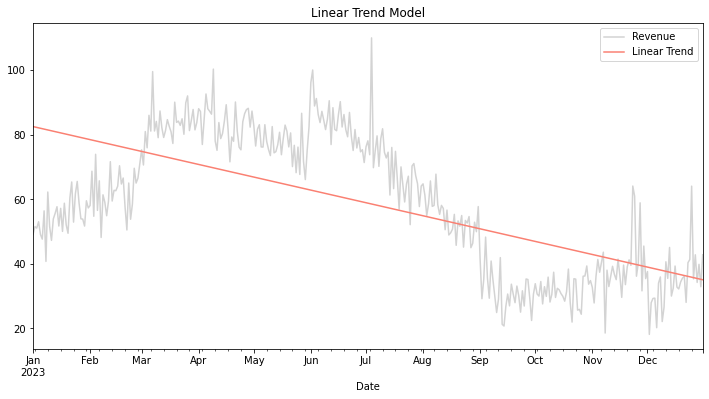

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
revenue_df['Revenue'].plot(label='Revenue', color='lightgray')
plt.plot(revenue_df.index, linear_trend, label='Linear Trend', color='salmon')
plt.title('Linear Trend Model')
plt.legend()
plt.show()

In [ ]:
changepoints = [revenue_df.index.get_loc('2023-03-01'),
                revenue_df.index.get_loc('2023-06-01'),
                revenue_df.index.get_loc('2023-09-01'),
                revenue_df.index.get_loc('2023-12-01')]
models = {}
piecewise_trend = np.zeros(len(revenue_df))
for i, point in enumerate(changepoints):
    if i == 0:
        start = 0
        idx = slice(start, point)
    else:
        start = changepoints[i-1]
        idx = slice(start, point)
    model = OLS(y[idx], sm.add_constant(x[idx])).fit()
    piecewise_trend[idx] = model.predict(sm.add_constant(x[idx]))
    models[start] = model
cp_model = OLS(y[changepoints[-1]:], sm.add_constant(x[changepoints[-1]:])).fit()
piecewise_trend[changepoints[-1]:] = cp_model.predict(sm.add_constant(x[changepoints[-1]:]))
models[changepoints[-1]] = model

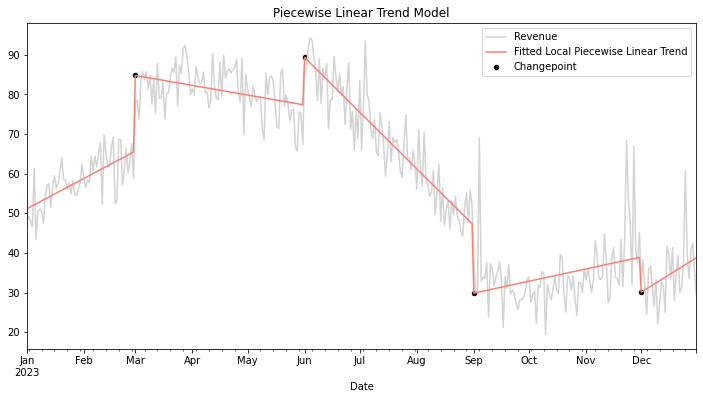

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
revenue_df['Revenue'].plot(label='Revenue', color='lightgray')
plt.plot(revenue_df.index, piecewise_trend, label='Fitted Local Piecewise Linear Trend', color='salmon')
label_added = False

for changepoint in changepoints:
    plot_data = revenue_df.iloc[changepoint, :]
    if not label_added:
        ax.scatter(plot_data.name, piecewise_trend[changepoint], color='black', s=20, label='Changepoint')
        label_added = True  
    else:
        ax.scatter(plot_data.name, piecewise_trend[changepoint], color='black', s=20)
plt.title('Piecewise Linear Trend Model')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    # this is from https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_local_linear_trend.html
    def __init__(self, endog):
        k_states = k_posdef = 2
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1], [0, 1]])
        self.ssm['selection'] = np.eye(k_states)
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)
        self.ssm['obs_cov', 0, 0] = params[0]
        self.ssm[self._state_cov_idx] = params[1:]


In [ ]:
llt_model = LocalLinearTrend(revenue_df['Revenue'])
llt_fit = llt_model.fit(disp=False)

/home/hexuser/.cache/pypoetry/virtualenvs/python-kernel-OtKFaj5M-py3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


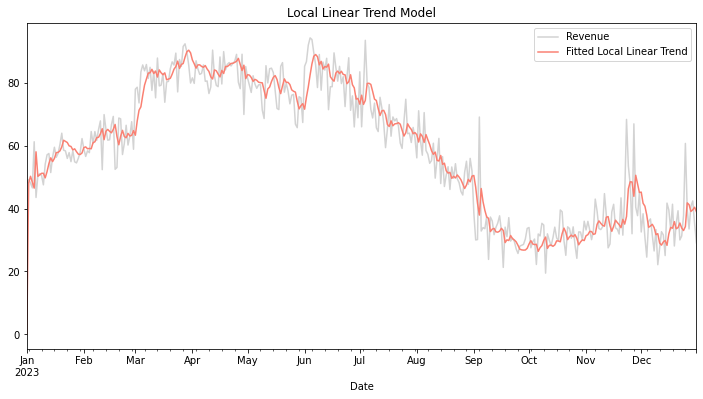

In [ ]:
fitted_vals = llt_fit.predict(start=revenue_df.index[0], end=revenue_df.index[-1])

fig, ax = plt.subplots(figsize=(12, 6))
revenue_df['Revenue'].plot(label='Revenue', color='lightgray')
plt.plot(revenue_df.index, fitted_vals, label='Fitted Local Linear Trend', color='salmon')
plt.title('Local Linear Trend Model')
plt.legend()
plt.show()

In [ ]:
cp_idx = changepoints[-1]


In [ ]:
x_train = np.arange(0, cp_idx)
y_train = revenue_df['Revenue'].values[:cp_idx]
linear_model = OLS(y_train, sm.add_constant(x_train)).fit()
linear_trend = linear_model.predict(sm.add_constant(x_train))
x_test = np.arange(x_train[-1] + 1, x_train[-1] + 1 + (len(revenue_df) - cp_idx))
lt_y_test = linear_model.predict(sm.add_constant(x_test))

In [ ]:
#piecewise
cp_forecast_model = models[cp_idx]
cp_y_test = cp_forecast_model.predict(sm.add_constant(x_test))

In [ ]:
llt_model = LocalLinearTrend(y_train)
llt_fit = llt_model.fit(disp=False)

In [ ]:
llt_model = LocalLinearTrend(y_train)
llt_fit = llt_model.fit(disp=False)
llt_fitted_vals = llt_fit.predict(start=0, end=x_test[0]-1)
llt_pred_vals = llt_fit.predict(start=x_test[0], end=x_test[-1])

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), )
revenue_df['Revenue'].plot(label='Revenue', color='lightgray', ax=ax)

ax.plot(revenue_df.index[:cp_idx], linear_trend, label='Fitted Linear Trend', color='salmon')
ax.plot(revenue_df.index[cp_idx:], lt_y_test, color='teal', ls='--', label='Predicted Linear Trend')
ax.set_title('Linear Trend Model')
fig.legend()
fig.show()

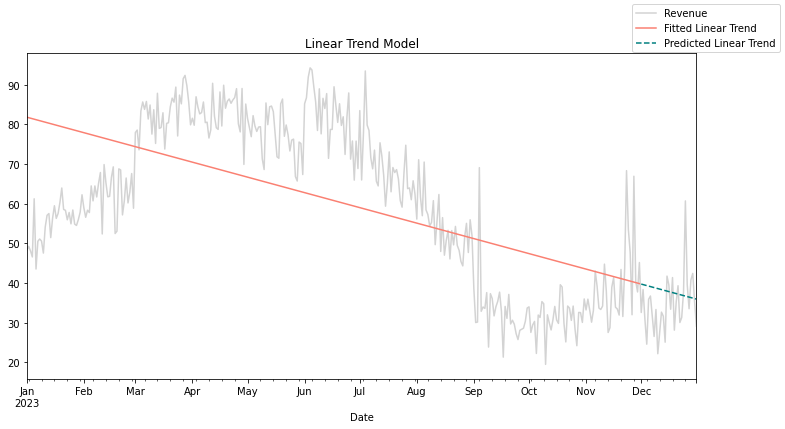

In [ ]:
fig, axes = plt.subplots(figsize=(12, 18), nrows=3)
revenue_df['Revenue'].plot(label='Revenue', color='lightgray', ax=ax)

axes[0].plot(revenue_df.index[:cp_idx], linear_trend, label='Fitted Linear Trend', color='salmon')
axes[0].plot(revenue_df.index[cp_idx:], lt_y_test, color='teal', ls='--', label='Predicted Linear Trend')
axes[0].set_title('Linear Trend Model')

axes[1].plot(revenue_df.index[:cp_idx], piecewise_trend[:cp_idx], label='Fitted Piecewise Linear Trend', color='salmon')
axes[1].plot(revenue_df.index[cp_idx:], cp_y_test, color='teal', ls='--', label='Predicted Piecewise Linear Trend')
axes[1].set_title('Piecewise Linear Trend Model')

axes[2].plot(revenue_df.index[:cp_idx], llt_fitted_vals, label='Fitted Local Linear Trend', color='salmon')
axes[2].plot(revenue_df.index[cp_idx:], llt_pred_vals, color='teal', ls='--', label='Predicted Local Linear Trend')
axes[2].set_title('Linear Trend Model')

axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()

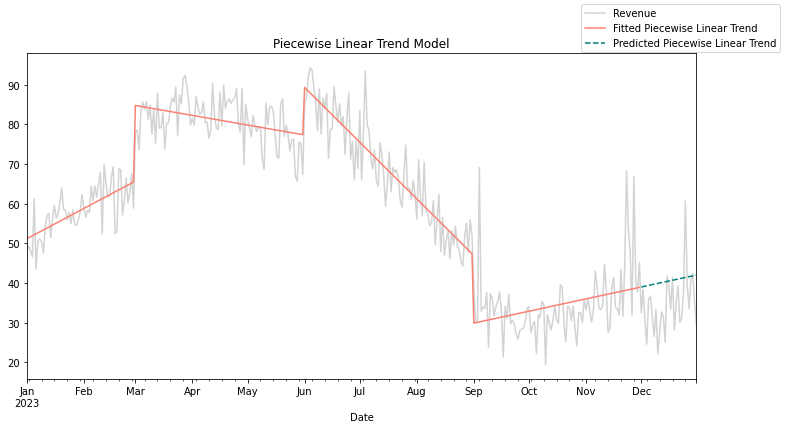

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), )
revenue_df['Revenue'].plot(label='Revenue', color='lightgray', ax=ax)

ax.plot(revenue_df.index[:cp_idx], piecewise_trend[:cp_idx], label='Fitted Piecewise Linear Trend', color='salmon')
ax.plot(revenue_df.index[cp_idx:], cp_y_test, color='teal', ls='--', label='Predicted Piecewise Linear Trend')
ax.set_title('Piecewise Linear Trend Model')
fig.legend()
fig.show()

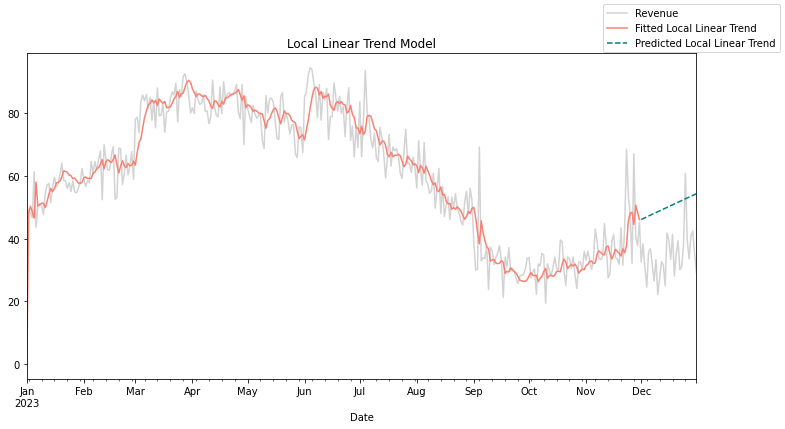

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), )
revenue_df['Revenue'].plot(label='Revenue', color='lightgray', ax=ax)

ax.plot(revenue_df.index[:cp_idx], llt_fitted_vals, label='Fitted Local Linear Trend', color='salmon')
ax.plot(revenue_df.index[cp_idx:], llt_pred_vals, color='teal', ls='--', label='Predicted Local Linear Trend')
ax.set_title('Local Linear Trend Model')
fig.legend()
fig.show()

In [ ]:
x_train = np.arange(0, cp_idx)
y_train = revenue_df['Revenue'].values[:cp_idx]
linear_model = OLS(y_train, sm.add_constant(x_train)).fit()
linear_trend = linear_model.predict(sm.add_constant(x_train))
x_test = np.arange(x_train[-1] + 1, x_train[-1] + 1 + (len(revenue_df) - cp_idx))
lt_y_test = linear_model.predict(sm.add_constant(x_test))

In [ ]:
segments = np.arange(0, len(revenue_df), 30)

In [ ]:
for i in range(1, len(segments)-1):
    y_train = revenue_df.Revenue.values[0:segments[i]]
    x_train = np.arange(0, segments[i], 1)
    llt_model = LocalLinearTrend(y_train)
    llt_fit = llt_model.fit(disp=False)
    llt_fitted_vals = llt_fit.predict(start=0, end=x_test[0]-1)
    llt_pred_vals = llt_fit.predict(start=x_test[0], end=x_test[-1])

In [ ]:
llt_model = LocalLinearTrend(y_train)
llt_fit = llt_model.fit(disp=False)
llt_fitted_vals = llt_fit.predict(start=0, end=x_test[0]-1)
llt_pred_vals = llt_fit.predict(start=x_test[0], end=x_test[-1])